In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sn
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_colwidth',200)

nltk.download('stopwords')
nltk.download('punkt')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data/bbc'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/bbc/BBC News Train.csv
./data/bbc/BBC News Test.csv
./data/bbc/BBC News Sample Solution.csv
./data/bbc/learn-ai-bbc.zip


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexmohelsky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/alexmohelsky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# helper function to clean up text so that machine learning algo can work better on it
# for example, removing very commmon words that don't give much extra value, i.e. stopwords containing things 
# like 'the'
# isolate and remove punctionations
# standardize contractions like 'can't' to 'can not'
# remove special characters

def preprocess_text_col(df, col) :
    new_text = []
    english_stopwords = set(stopwords.words('english'))
    for (offset,line) in enumerate(df[col]):
        
        line = line.lower()
        # Change 't to 'not'
        line = re.sub(r"\'t", " not", line)
        # Remove @name
        line = re.sub(r'(@.*?)[\s]', ' ', line)
        # Isolate and remove punctuations except '?'
        line = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', line)
        line = re.sub(r'[^\w\s\?]', ' ', line)
        # Remove some special characters
        line = re.sub(r'([\;\:\|•«\n])', ' ', line)
    
        tokens = nltk.word_tokenize(line)
        filtered =[]


        for word in tokens:
            if not word.lower() in english_stopwords:
                filtered.append(word)

        new_text.append(' '.join(filtered))

    return new_text

## 1.  Exploratory Data Analysis

The 'BBC News Train.csv' file has an ArticleID column, a Text column that contains text, and Category column that contains the type of new collumn which is the target variable we are trying to predict.

 It is typical to perform preprocessing on text to remove stopwords from text that is being used for model training. Stopwords are common words that do not convey much information such as 'the'. It is also common to remove punction, special characters, and to standardize contractions. The text in the Text column is shown before the preprocessing and after the preprocessing.

 There are 5 Category values: Business, Tech, Politics, Sport, and Entertainment. The histogram to display the number of each value shows that these classes are fairly balanced which is a good thing, i.e. no need to try to balance the classes.

In [4]:
df = pd.read_csv('./data/bbc/BBC News Train.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness. cynthia coop...,business
1,154,german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy. munich-based research institute ifo said that its co...,business
2,1101,bbc poll indicates economic gloom citizens in a majority of nations surveyed in a bbc world service poll believe the world economy is worsening. most respondents also said their national economy ...,business
3,1976,lifestyle governs mobile choice faster better or funkier hardware alone is not going to help phone firms sell more handsets research suggests. instead phone firms keen to get more out of the...,tech
4,917,enron bosses in $168m payout eighteen former enron directors have agreed a $168m (£89m) settlement deal in a shareholder lawsuit over the collapse of the energy firm. leading plaintiff the unive...,business


In [5]:
df['preproc_text'] = preprocess_text_col(df, "Text")
df.head()

,ArticleId,Text,Category,preproc_text
0,1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness. cynthia coop...,business,worldcom ex boss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom ex head internal ac...
1,154,german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy. munich-based research institute ifo said that its co...,business,german business confidence slides german business confidence fell february knocking hopes speedy recovery europe largest economy munich based research institute ifo said confidence index fell 95 5...
2,1101,bbc poll indicates economic gloom citizens in a majority of nations surveyed in a bbc world service poll believe the world economy is worsening. most respondents also said their national economy ...,business,bbc poll indicates economic gloom citizens majority nations surveyed bbc world service poll believe world economy worsening respondents also said national economy getting worse asked family financ...
3,1976,lifestyle governs mobile choice faster better or funkier hardware alone is not going to help phone firms sell more handsets research suggests. instead phone firms keen to get more out of the...,tech,lifestyle governs mobile choice faster better funkier hardware alone going help phone firms sell handsets research suggests instead phone firms keen get customers pushing technology sake consumers...
4,917,enron bosses in $168m payout eighteen former enron directors have agreed a $168m (£89m) settlement deal in a shareholder lawsuit over the collapse of the energy firm. leading plaintiff the unive...,business,enron bosses 168m payout eighteen former enron directors agreed 168m 89m settlement deal shareholder lawsuit collapse energy firm leading plaintiff university california announced news adding 10 f...


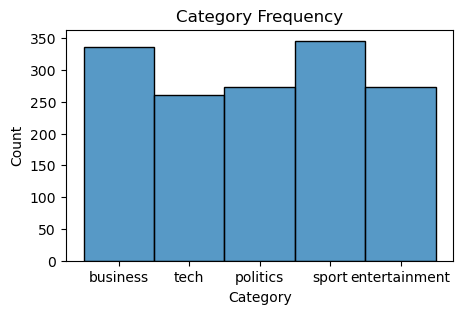

In [6]:
plt.subplots(figsize=(5, 3))
sn.histplot(data = df,x = 'Category').set(title = 'Category Frequency');

The following code is taken from previous assignment I submitted. It is used to assigned a clustering algorithms clusters to the human interpretable labels as well as create an accuracy score.

In [7]:
def predict_helper(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    preds = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        preds[i] = predictions[i][0]
        
    return preds

In [8]:
def label_permute_compare(ytdf,col, yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # Referenced 
    # https://stackoverflow.com/questions/11683785/
    #         how-can-i-match-up-cluster-labels-to-my-ground-truth-labels-in-matlab
    # to develop the following code
    
    labelorder = []
    acc = 0
    label_dict = {}
    type(yp)
    pred_cluster_labels = np.unique(yp)
    
    # map true label values to integers to we can then use them to compare to 
    # permuations of labels
    labels = ytdf[col].unique() # get the label values
    for i, label in enumerate(labels):
        label_dict[label] = i
    ytdf['pred']=ytdf[col].map(label_dict)
    
    # for each permuation of the labels, compare to new lable column to measure accuracy
    from itertools import permutations   
    # we need perumations of integer set with elements 0-4
    perms = permutations(range(len(labels)))  
    
    for p in perms:
        converted_labels = np.zeros(len(ytdf))
        for i, label in enumerate(pred_cluster_labels):
            converted_labels[yp == label] = p[i]
        test_acc = np.sum(converted_labels == ytdf['pred']) / len(ytdf)
        if test_acc > acc:
            acc = test_acc
            labelorder = p
                  
    return labels, labelorder, round(acc,4)

In [9]:
def unsupervised_predict_on_training_data(model, df, cat):

    preds_arr = predict(model,df)
    labels, label_order, accuracy = label_permute_compare(df, cat, preds_arr )
    cluster_map = {}
    
    for c,l in zip(label_order, labels):
        cluster_map[c]=l
        
    print('accuracy=', accuracy)
    print(cluster_map)
    
    preds = pd.DataFrame(df['ArticleId'])
    preds['Category'] = pd.Series(preds_arr).map(cluster_map)

    return preds, cluster_map

In [10]:
def predict(model,df):
        #create vectorizer
    v_train = TfidfVectorizer(min_df = 2,max_df = 0.95, norm = 'l2').fit_transform(df['preproc_text'])

    model.fit(v_train)

    preds_arr = predict_helper(model.transform(v_train))
    
    return preds_arr

## 2. Scikit-Learns Non-Negative Matrix Factoriztion

NVM from scikit-learn is used to form clusters by a predicted topic. Then the cluster names are compared against the original categories see how accurate the clustering was.

In [11]:
model = NMF(n_components=5, 
            init='nndsvda', 
            solver = 'mu',
            beta_loss = 'kullback-leibler',
            l1_ratio = 0.5,
            random_state = 101)

pred_cluster_labels = np.unique(df["Category"])
print(pred_cluster_labels)
preds, cluster_map = unsupervised_predict_on_training_data(model, df, "Category")

['business' 'entertainment' 'politics' 'sport' 'tech']
accuracy= 0.9564
{3: 'business', 2: 'tech', 1: 'politics', 4: 'sport', 0: 'entertainment'}


NVM resulted in an accuracy of 95.7%.

In [12]:
print(preds.head())
print(cluster_map)

   ArticleId Category
0       1833    sport
1        154    sport
2       1101    sport
3       1976     tech
4        917    sport
{3: 'business', 2: 'tech', 1: 'politics', 4: 'sport', 0: 'entertainment'}


In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['preproc_text'], df['Category'], test_size=0.25, random_state=0)

model = Pipeline([('tfidf',TfidfVectorizer(min_df = 2,max_df = 0.95, norm = 'l2') ),
                  ('rfc', RandomForestClassifier(n_estimators=100)),
                ])

model.fit(x_train, y_train)

predict = model.predict(x_test)
print("Supervise Learning Accuracy: " + str(accuracy_score(predict, y_test)))




Supervise Learning Accuracy: 0.9517426273458445


Supervised learning using Random Forest was NVM whas an accuracy of 95.2% which is slightly worse than the using NVM which had an accuracy of 95.7%.